https://chatgpt.com/share/c75315ed-f7f8-48c5-8638-b1f162876fa4


## Predicting Soccer Mathces Using Variational Inference 

To learn new complex technical concepts, I always like to use an interesting application. Something that the outcome is so appealing that force ourselves to keep going despite how hard some parts of the concept might be.

Well, I am no big soccer fan, but being able to predict their results is something that always caught my attention. Given how big betting\* sites are today, I believe I am not the only one.



 <sub>*DO NOT use this model to bet. It is really simplified. You WILL lose money.*</sub>

### So, let's try to do it!

To start, we need to define a basic probabilistic model, how the results are draw.

We may assume that the number of goals of each team are independent of each other, this might not be totally realistic, but simple a lot at little loss. The standard choice for any problem where things arrive randomly(either goals, people in a place or lightnings in a area) is the Poisson process. In a Poisson process, the number of events in a period, in our case the full match, follows a Poisson distribution.

$$
P(\rm{Goal} = g | \lambda) = \frac{\lambda^{g} e^{-\lambda}}{g!}
$$

Where $\lambda$ is the rate of the events, with $\mathbb{E}[g] = \lambda$.


It is also sensible to say that a goal is the result of the interaction between one teams attack ($\alpha$) against the other team defense ($\beta$). There is also the home advantage ($\gamma$) that plays an important role. So, we can define the Home ($h$) and Away ($a$) teams rates as:

$$
\lambda^{h} = \alpha^{h} + \gamma - \beta^{a} \\
\lambda^{a} = \alpha^{a} - \beta^{h}
$$

We can try many different combinations here. We can multiply instead of sum, have a home advantage for the defense, add extra parameters for the weather, altitude etc, but this model has a good balance between complexity, tractability and avoiding overfitting (the more degrees of freedom, easier it is to overfit). We will also assume that $\gamma$ is the same for all teams and fixed in time. 


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.optimize import minimize, NonlinearConstraint

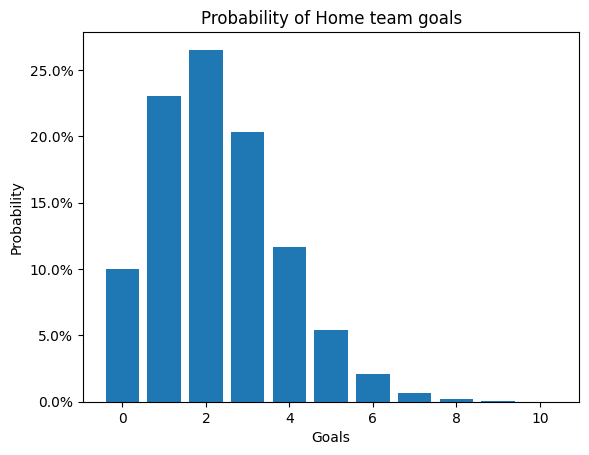

In [2]:
gamma = 1.1
home_atk = 3
away_def = 1

lambda_ = gamma*home_atk - away_def 

goals = np.arange(0, 11)

factorial = np.vectorize(math.factorial)

pois = lambda g: (lambda_ ** g)*np.exp(-lambda_)/factorial(g)

plt.bar(goals, pois(goals))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Goals')
plt.ylabel('Probability')
plt.title('Probability of Home team goals')
plt.show()

Nice, we have our base model. Now we need to find

In [6]:
data = pd.read_csv('english_championship.csv', sep=';')

In [7]:
data

,home,away,home_goal,away_goal
0,Manchester United,Leicester City,2,1
1,Newcastle United,Tottenham Hotspur,1,2
2,AFC Bournemouth,Cardiff City,2,0
3,Fulham,Crystal Palace,0,2
4,Huddersfield Town,Chelsea,0,3
...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0
376,Manchester United,Cardiff City,0,2
377,Southampton,Huddersfield Town,1,1
378,Tottenham Hotspur,Everton,2,2


In [8]:
teams = pd.unique(data[['home', 'away']].values.ravel('K'))
teams_params = pd.DataFrame({
    'Team': teams,
    'alpha': 5,
    'beta': 2
})

teams_params.set_index('Team', inplace=True)

In [9]:
len(data)

380

In [120]:
n_train = 150
n_validation = 200

data_train = data[:n_train]
data_validation = data[n_train:n_validation]
data_test = data[n_validation:]


In [121]:
data_validation

,home,away,home_goal,away_goal
150,AFC Bournemouth,Liverpool,0,4
151,Arsenal,Huddersfield Town,1,0
152,Burnley,Brighton & Hove Albion,1,0
153,Cardiff City,Southampton,1,0
154,Manchester United,Fulham,4,1
155,West Ham United,Crystal Palace,3,2
156,Chelsea,Manchester City,2,0
157,Leicester City,Tottenham Hotspur,0,2
158,Newcastle United,Wolverhampton Wanderers,1,2
159,Everton,Watford,2,2


In [122]:
def log_likelihood(params, data, teams=None):
    
    ## Pass params as [data_test_compare, gamma]
    if len(params) == 2:
        gamma = params[1]
        params_data_test_compare = params[0]
    
    # Pass params as flatten data_test_compare and gamma
    # Reconstruct the data_test_compare
    else:
        gamma = params[-1]
        params = params[:-1]
        params_data_test_compare = pd.DataFrame({
            'Team': teams,
            'alpha': params[:len(teams)],
            'beta': params[len(teams):2*len(teams)]
        }).set_index('Team')
    
    total_sum = 0
    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        alpha_h = params_data_test_compare.at[name_h, 'alpha']
        beta_h = params_data_test_compare.at[name_h, 'beta']

        alpha_a = params_data_test_compare.at[name_a, 'alpha']
        beta_a = params_data_test_compare.at[name_a, 'beta']
        

        lambda_h = gamma + alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        row_sum = poisson.logpmf(home_goal, lambda_h) + poisson.logpmf(away_goal, lambda_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [123]:
# Initial guess
initial_params = teams_params.values.T.flatten().tolist() + [1]  # Flatten alpha and beta, and add initial gamma

In [124]:
log_likelihood(initial_params, data_train, teams_params.index.tolist())

699.0699037028917

In [125]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params)-1)/2)
    a = params[:n]
    b = params[n:2*n]
    c = params[-1]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj - 0.5)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [126]:
# Bounds for alpha, beta, and gamma
a1, a2 = 0, 10.0  # Bounds for alpha
b1, b2 = 0.0, 6.0  # Bounds for beta
c1, c2 = 0.0, 3.0  # Bounds for gamma
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams) + [(c1, c2)]


# Optimize
result = minimize(log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints)

In [127]:
# Get the results and re-create the data_test_compare

optimized_params = result.x
optimized_gamma = optimized_params[-1]
optimized_alphas = optimized_params[:len(teams)]
optimized_betas = optimized_params[len(teams):2*len(teams)]

# Create the optimized DataFrame
optimized_teams_params = pd.DataFrame({
    'Team': teams,
    'alpha': optimized_alphas,
    'beta': optimized_betas
}).set_index('Team')

In [128]:
log_likelihood(optimized_params, data_train, teams)

402.6899761576098

In [129]:
print(f'Optimal Home Advantage: {optimized_gamma}')

Optimal Home Advantage: 0.08502203230502513


In [130]:
optimized_teams_params

,alpha,beta
Team,,
Manchester United,4.457079,2.601395
Newcastle United,3.731366,3.039422
AFC Bournemouth,4.446242,2.715643
Fulham,3.731366,1.884014
Huddersfield Town,3.731366,2.666222
Watford,3.903981,2.914690
Wolverhampton Wanderers,3.876359,2.948000
Liverpool,4.697941,3.231366
Southampton,3.731366,2.487422


In [131]:
data_test_compare = data_test.copy()

In [132]:
def results_probability(lambda_h, lambda_a):

    win, draw, lose = 0.,0.,0.

    for score_h in range(10):
        for score_a in range(10):
            prob = poisson.pmf(score_h, lambda_h) * poisson.pmf(score_a, lambda_a)

            if score_h > score_a:
                win += prob
            elif score_h < score_a:
                lose += prob
            else:
                draw += prob

    return win, draw, lose


In [133]:
for idx, row in data_test_compare.iterrows():
    name_h = row['home']
    name_a = row['away']


    optimized_teams_params

    alpha_h = optimized_teams_params.at[name_h, 'alpha']
    beta_h = optimized_teams_params.at[name_h, 'beta']

    alpha_a = optimized_teams_params.at[name_a, 'alpha']
    beta_a = optimized_teams_params.at[name_a, 'beta']


    lambda_h = gamma*alpha_h - beta_a
    lambda_a = alpha_a - beta_h

    win, draw, lose = results_probability(lambda_h, lambda_a)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    rps_ = [win, draw, lose]

    if home_goal > away_goal:
        data_test_compare.loc[idx, 'outcome'] = 1
        rps_[0] -= 1 
    elif home_goal < away_goal:
        data_test_compare.loc[idx, 'outcome'] = -1
        rps_[2] -= 1 
    else:
        data_test_compare.loc[idx, 'outcome'] = 0
        rps_[1] -= 1

    rps = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps_[i]**2
        for j in range(i+1):
            s += rps_[j]

        rps += s**2
        

        


    data_test_compare.loc[idx, 'win_prob'] = win
    data_test_compare.loc[idx, 'draw_prob'] = draw
    data_test_compare.loc[idx, 'lose_prob'] = lose
    data_test_compare.loc[idx, 'RPS'] = rps/2
    data_test_compare.loc[idx, 'BS'] = bs/3


In [134]:
data_test_compare

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,0,1,-1.0,0.428365,0.263252,0.308380,0.330916,0.243712
201,Arsenal,Fulham,4,1,1.0,0.867797,0.081964,0.045619,0.010011,0.008759
202,Cardiff City,Tottenham Hotspur,0,3,-1.0,0.155757,0.193740,0.650408,0.073204,0.061337
203,Chelsea,Southampton,0,0,0.0,0.831263,0.120207,0.048077,0.346676,0.489115
204,Huddersfield Town,Burnley,1,2,-1.0,0.592983,0.212149,0.194819,0.499933,0.348318
...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,1.0,0.733973,0.172900,0.093018,0.039721,0.036439
376,Manchester United,Cardiff City,0,2,-1.0,0.664811,0.177355,0.157590,0.575608,0.394361
377,Southampton,Huddersfield Town,1,1,0.0,0.415967,0.257745,0.326285,0.139746,0.276811
378,Tottenham Hotspur,Everton,2,2,0.0,0.639360,0.201101,0.159471,0.217117,0.357484


In [135]:
print(data_test_compare['RPS'].mean())

0.20059995432701555


In [136]:
data_test_compare['BS'].mean()

np.float64(0.18140475833785533)

For reference, the RPS and BS of the odds-implied probability are 0.196696 and 0.1799, respectively. RECALCULAR

What if instead I maximized the RPS directly?

In [30]:
import pandas as pd
from scipy.stats import poisson

def rps(params, data, teams=None, max_goals=10):
    
    ## Pass params as [data_test_compare, gamma]
    if len(params) == 2:
        gamma = params[1]
        params_data_test_compare = params[0]
    
    # Pass params as flatten data_test_compare and gamma
    # Reconstruct the data_test_compare
    else:
        gamma = params[-1]
        params = params[:-1]
        params_data_test_compare = pd.DataFrame({
            'Team': teams,
            'alpha': params[:len(teams)],
            'beta': params[len(teams):2*len(teams)]
        }).set_index('Team')
    
    total_rps = 0
    n = len(data)
    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        alpha_h = params_data_test_compare.at[name_h, 'alpha']
        beta_h = params_data_test_compare.at[name_h, 'beta']

        alpha_a = params_data_test_compare.at[name_a, 'alpha']
        beta_a = params_data_test_compare.at[name_a, 'beta']

        lambda_h = gamma + alpha_h - beta_a
        lambda_a = alpha_a - beta_h

        # Compute the cumulative probabilities for the RPS calculation
        rps_home = 0
        rps_away = 0
        
        for k in range(max_goals + 1):
            p_k_home = poisson.cdf(k, lambda_h)
            p_k_away = poisson.cdf(k, lambda_a)
            
            i_k_home = 1 if home_goal <= k else 0
            i_k_away = 1 if away_goal <= k else 0
            
            rps_home += (p_k_home - i_k_home) ** 2
            rps_away += (p_k_away - i_k_away) ** 2
        
        total_rps += (rps_home + rps_away) / 2
    
    return total_rps / n

In [31]:
# Initial guess
initial_params = teams_params.values.T.flatten().tolist() + [1]  # Flatten alpha and beta, and add initial gamma

In [32]:
rps(initial_params, data_train, teams_params.index.tolist())

np.float64(1.4230615154129371)

In [33]:
# Bounds for alpha, beta, and gamma
a1, a2 = 0, 10.0  # Bounds for alpha
b1, b2 = 0.0, 5.0  # Bounds for beta
c1, c2 = 0.0, 3.0  # Bounds for gamma
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams) + [(c1, c2)]




# Optimize
result = minimize(rps, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

KeyboardInterrupt: 

In [576]:
# Get the results and re-create the data_test_compare

optimized_params = result.x
optimized_gamma = optimized_params[-1]
optimized_alphas = optimized_params[:len(teams)]
optimized_betas = optimized_params[len(teams):2*len(teams)]

# Create the optimized DataFrame
optimized_teams_params = pd.DataFrame({
    'Team': teams,
    'alpha': optimized_alphas,
    'beta': optimized_betas
}).set_index('Team')

In [577]:
rps(optimized_params, data_train, teams)

np.float64(0.5823563395697061)

In [568]:
print(f'Optimal Home Advantage: {optimized_gamma}')

Optimal Home Advantage: 0.13679399568649195


In [578]:
optimized_teams_params

,alpha,beta
Team,,
Manchester United,4.029255,2.907532
Newcastle United,3.588466,3.079624
AFC Bournemouth,4.140061,2.991207
Fulham,3.781474,2.442829
Huddersfield Town,3.562544,2.834216
Watford,3.847657,3.048265
Wolverhampton Wanderers,3.654274,3.174581
Liverpool,4.333590,3.562544
Southampton,3.634854,2.670958


In [579]:
data_test_compare = data_test.copy()

In [49]:
for idx, row in data_test_compare.iterrows():
    name_h = row['home']
    name_a = row['away']


    optimized_teams_params

    alpha_h = optimized_teams_params.at[name_h, 'alpha']
    beta_h = optimized_teams_params.at[name_h, 'beta']

    alpha_a = optimized_teams_params.at[name_a, 'alpha']
    beta_a = optimized_teams_params.at[name_a, 'beta']


    lambda_h = gamma*alpha_h - beta_a
    lambda_a = alpha_a - beta_h

    win, draw, lose = results_probability(lambda_h, lambda_a)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    rps__ = [win, draw, lose]

    if home_goal > away_goal:
        data_test_compare.loc[idx, 'outcome'] = 1
        rps__[0] -= 1 
    elif home_goal < away_goal:
        data_test_compare.loc[idx, 'outcome'] = -1
        rps__[2] -= 1 
    else:
        data_test_compare.loc[idx, 'outcome'] = 0
        rps__[1] -= 1

    rps_ = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps__[i]**2
        for j in range(i+1):
            s += rps__[j]

        rps_ += s**2
        

        


    data_test_compare.loc[idx, 'win_prob'] = win
    data_test_compare.loc[idx, 'draw_prob'] = draw
    data_test_compare.loc[idx, 'lose_prob'] = lose
    data_test_compare.loc[idx, 'RPS'] = rps_/2
    data_test_compare.loc[idx, 'BS'] = bs/3


In [50]:
data_test_compare

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,0,1,-1.0,0.415020,0.260436,0.324540,0.314242,0.232105
201,Arsenal,Fulham,4,1,1.0,0.882835,0.076064,0.036874,0.007717,0.006958
202,Cardiff City,Tottenham Hotspur,0,3,-1.0,0.182492,0.197920,0.619489,0.089008,0.072422
203,Chelsea,Southampton,0,0,0.0,0.843947,0.115278,0.040342,0.356954,0.498869
204,Huddersfield Town,Burnley,1,2,-1.0,0.569426,0.224349,0.206199,0.477162,0.334899
...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,1.0,0.831954,0.138707,0.029237,0.014550,0.016111
376,Manchester United,Cardiff City,0,2,-1.0,0.635654,0.182132,0.181967,0.536416,0.368802
377,Southampton,Huddersfield Town,1,1,0.0,0.434188,0.266323,0.299487,0.139106,0.272165
378,Tottenham Hotspur,Everton,2,2,0.0,0.660018,0.193725,0.146171,0.228508,0.369023


In [51]:
print(data_test_compare['RPS'].mean())

0.19877833898632044


In [52]:
data_test_compare['BS'].mean()

np.float64(0.18008467845588635)

We have used a fixed set to find out parameters and kept them fixed throughout the rest of the championship.

But things change. Players are injured, coaches change, teams get better, teams get worse...

Given that we do not have access to the news, how can we use our dataset to infer how our parameters change in time? We could use a moving window approach, by removing the week and adding the last week. But this approach has two drawbacks: it's computationally intensive as we have to optimize at each week and we are wasting information by tossing out the oldest week.

A better approach is to use the marvelous:

<center>&#9733;<font size="5">Bayes' Theorem</font>&#9733;</center>

Recap, the Bayes' theorem state that

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

As $P(B)$ is usually not readily available, we use

$$
P(B) = \int_{\Omega} P(B|A)P(A) dA \quad  \rm{or} \quad P(B) = \sum_{i=1} P(B|A_i)P(A_i)
$$


Our aim is to update our set of parameter $\Lambda = (\alpha^h, \beta^h, \alpha^a, \beta^a)$ (we will assume the home advantage to be fixed), given the score of the game $G$. To make things easier, we will parametrize with respect the variation of the parameters, i.e. how much should we add or subtract from the parameters. Let's call it $\theta = (\Delta\alpha^h, \Delta\beta^h, \Delta\alpha^a, \Delta\beta^a)$. At each game we update as:

$$
\Lambda \leftarrow \Lambda + \theta
$$

Hence, our Bayesian formula is:

$$
P(\theta|G) = \frac{P(G|\theta)P(\theta)}{P(G)}
$$

In the Bayesian framework, we have to define $P(\theta)$, a prior for distribution of $\theta$. In other words, the probability distribution of possible values of $\theta$, as if the "news" were drawn from a random generator machine.

Let's assume $P(\theta)$ follows a multivariate normal distribution (4 dimensions, one for each parameter). It's fair to assume there is no tendency of a team to improve or get worst with time, so assume the mean of the distribution is $\vec{0}$. For the covariance matrix, we may assume that the news regarding each team are independent (why would they be correlated?), but the $\alpha$ and $\beta$ variations are correlated. The standard deviation and correlation within the team are the same for all teams.


$$
\Sigma = \begin{bmatrix}
\sigma_{\alpha}^2 & \sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} & 0 & 0 \\
\sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} & \sigma_{\beta}^2 & 0 & 0 \\
0 & 0 & \sigma_{\alpha} & \sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} \\
0 & 0 & \sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} & \sigma_{\beta}^2 
\end{bmatrix}
$$


There are 3 hyperparameters: $\sigma_{\alpha}$, $\sigma_{\beta}$, $\rho_{\alpha, \beta}$. Their choice could be guided by expert knowledge or by cross-validation on the validation set.

So far, so good, so far...

First problem is that we don't know $P(G)$. One solution is to numerically compute the integral, but that is highly non-advised, as it is actually a quadruple integral. Another alternative is to notice that it is just a normalization constant and we don't really needed it. We can use Markov Chain Monte Carlo (MCMC) techniques to generate samples of $P(\theta |G)$. Packages like PyMC3 offer powerful MCMC implementations, but it is still slow and cumbersome to implement.

But due we really need the full distribution of $\theta$? Wouldn't A value, representative, be enough? Maybe just the most probable one? Well, actually, that is enough. No we must find $\theta$ which maximize $P(\theta|G)$, applying the log:

$$
\arg\max_{\theta} [\log P(G|\theta) + \log P(\theta)]
$$


As G is actually two values, the home and away goals, $G = (G^h, G^a)$. And notice that $P(G_{h,a}|\theta)$ is Poisson with parameter the sum of the current parameter and their variations. Substituting the distributions:

$$
\log P(\theta) = -\frac{1}{2}[\log(|\Sigma|) + \theta^T \Sigma^{-1}\theta + 4\log(2\pi)]
$$


$$
\log P(G|\theta) = \log P(G^h|\theta) + \log P(G^a|\theta) = \\ G^h \log(\alpha^{h} + \gamma - \beta^{a} + \Delta\alpha^h - \Delta\beta^a) - (\alpha^{h} + \gamma - \beta^{a} + \Delta\alpha^h - \Delta\beta^a) - \log(G^h!) +\\
G^a \log(\alpha^{a} - \beta^{h} + \Delta\alpha^a - \Delta\beta^h) - (\alpha^{a} - \beta^{h} + \Delta\alpha^a - \Delta\beta^h) - \log(G^a!)
$$


Thus, putting all together and removing the constants, our objective is:

$$
\arg \max_{\Delta\alpha^h, \Delta\beta^h, \Delta\alpha^a, \Delta\beta^a} = -\theta^T \Sigma^{-1}\theta + G^h \log(\alpha^{h} + \gamma - \beta^{a} + \Delta\alpha^h - \Delta\beta^a) + \\ G^a \log(\alpha^{a} - \beta^{h} + \Delta\alpha^a - \Delta\beta^h) - (\Delta\alpha^h - \Delta\beta^a + \Delta\alpha^a - \Delta\beta^h)
$$

Ok, ok, this objective function looks nasty, but it is actually simple, just long.

In [137]:
def cov_matrix(sigma_alpha, sigma_beta, rho):
    return np.array([[sigma_alpha**2, sigma_alpha*sigma_beta*rho, 0, 0], 
                     [sigma_alpha*sigma_beta*rho, sigma_beta**2,  0, 0],
                     [0, 0, sigma_alpha**2, sigma_alpha*sigma_beta*rho], 
                     [0, 0, sigma_alpha*sigma_beta*rho, sigma_beta**2]])

In [138]:
def MAP_params(params, cov, G_h, G_a, alpha_h, beta_h, alpha_a, beta_a, gamma):
    
    Delta_alpha_h, Delta_beta_h, Delta_alpha_a, Delta_beta_a = np.array(params)/100
    
    Sigma_inv = np.linalg.inv(cov)
    
    term1 = -np.dot((np.array(params)/100).T, np.dot(Sigma_inv, np.array(params)/100))
    term2 = G_h * np.log(alpha_h + gamma - beta_a + Delta_alpha_h - Delta_beta_a)
    term3 = G_a * np.log(alpha_a - beta_h + Delta_alpha_a - Delta_beta_h)
    term4 = -(Delta_alpha_h - Delta_beta_a + Delta_alpha_a - Delta_beta_h)

    # print(term1)
    # print(term2)
    # print(term3)
    # print(term4)
    
    return -(term1 + term2 + term3 + term4)

In [112]:
cov = cov_matrix(0.3, 0.15, 0.5)

In [113]:
MAP_params([1,1,1,1], cov, 0, 4, 4.298, 2.807, 4.5594, 3.73, 0.27)

np.float64(-2.235056218941537)

In [114]:
from scipy.optimize import minimize, NonlinearConstraint

In [139]:
def delta_params(match, teams_params, gamma, cov_array):

    home = match.home
    away = match.away

    home_goal = match.home_goal
    away_goal = match.away_goal


    home_params = teams_params.loc[home]
    away_params = teams_params.loc[away]

    alpha_h = home_params.alpha
    beta_h = home_params.beta
    alpha_a = away_params.alpha
    beta_a = away_params.beta
    
    cov = cov_matrix(cov_array[0], cov_array[1], cov_array[2])

    initial_guess = np.array([0.0, 0.0, 0.0, 0.0])
    bounds = [(-100,100), (-100,100), (-100,100), (-100,100)]

    # Define the constraints
    def constraint1(params, alpha_h, beta_a, gamma):
        Delta_alpha_h, Delta_beta_h, Delta_alpha_a, Delta_beta_a = params
        return alpha_h + gamma - beta_a + Delta_alpha_h - Delta_beta_a

    def constraint2(params, alpha_a, beta_h):
        Delta_alpha_h, Delta_beta_h, Delta_alpha_a, Delta_beta_a = params
        return alpha_a - beta_h + Delta_alpha_a - Delta_beta_h
    
    nlc1 = NonlinearConstraint(lambda x: constraint1(x, alpha_h, beta_a, gamma), 0, np.inf)
    nlc2 = NonlinearConstraint(lambda x: constraint2(x, alpha_a, beta_h), 0, np.inf)


    result = minimize(MAP_params, initial_guess, args=(cov, home_goal, away_goal, alpha_h, beta_h, alpha_a, beta_a, gamma), bounds=bounds)


    return result.x/100



In [140]:
row_sum = poisson.logpmf(home_goal, lambda_h) + poisson.logpmf(away_goal, lambda_a)

In [141]:
data_validation_compare = data_validation.copy()
new_optimized = optimized_teams_params.copy()

In [142]:
for idx, row in data_validation_compare.iterrows():
    name_h = row['home']
    name_a = row['away']



    alpha_h = new_optimized.at[name_h, 'alpha']
    beta_h = new_optimized.at[name_h, 'beta']

    alpha_a = new_optimized.at[name_a, 'alpha']
    beta_a = new_optimized.at[name_a, 'beta']


    lambda_h = gamma*alpha_h - beta_a
    lambda_a = alpha_a - beta_h
    
    

    win, draw, lose = results_probability(lambda_h, lambda_a)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    

    rps__ = [win, draw, lose]

    if home_goal > away_goal:
        data_validation_compare.loc[idx, 'outcome'] = 1
        rps__[0] -= 1 
    elif home_goal < away_goal:
        data_validation_compare.loc[idx, 'outcome'] = -1
        rps__[2] -= 1 
    else:
        data_validation_compare.loc[idx, 'outcome'] = 0
        rps__[1] -= 1

    rps_ = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps__[i]**2
        for j in range(i+1):
            s += rps__[j]

        rps_ += s**2


    data_validation_compare.loc[idx, 'win_prob'] = win
    data_validation_compare.loc[idx, 'draw_prob'] = draw
    data_validation_compare.loc[idx, 'lose_prob'] = lose
    data_validation_compare.loc[idx, 'RPS'] = rps_/2
    data_validation_compare.loc[idx, 'BS'] = bs/3



In [143]:
data_validation_compare

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
150,AFC Bournemouth,Liverpool,0,4,-1.0,0.327550,0.215317,0.457080,0.200997,0.149471
151,Arsenal,Huddersfield Town,1,0,1.0,0.790309,0.128827,0.080025,0.025255,0.022324
152,Burnley,Brighton & Hove Albion,1,0,1.0,0.287896,0.224010,0.488062,0.372663,0.265159
153,Cardiff City,Southampton,1,0,1.0,0.451204,0.243826,0.304962,0.197092,0.151210
154,Manchester United,Fulham,4,1,1.0,0.751592,0.137212,0.110042,0.037036,0.030881
155,West Ham United,Crystal Palace,3,2,1.0,0.524396,0.258148,0.217452,0.136744,0.113375
156,Chelsea,Manchester City,2,0,1.0,0.326896,0.197265,0.475651,0.339745,0.239409
157,Leicester City,Tottenham Hotspur,0,2,-1.0,0.351493,0.242729,0.405770,0.238323,0.178525
158,Newcastle United,Wolverhampton Wanderers,1,2,-1.0,0.431566,0.303636,0.264798,0.363385,0.272988
159,Everton,Watford,2,2,0.0,0.528501,0.253945,0.217548,0.163322,0.294413


In [144]:
print(data_validation_compare['RPS'].mean())
print(data_validation_compare['BS'].mean())

0.23476474077496146
0.19343281903383683


In [187]:
data_validation_compare = data_validation.copy()
new_optimized = optimized_teams_params.copy()

In [188]:
## Função muito porca, tudo referenciando a variaveis externas.

def cross_optim(cov_array):

    data_validation_compare = data_validation.copy()
    new_optimized = optimized_teams_params.copy()

    for idx, row in data_validation_compare.iterrows():
    
        name_h = row['home']
        name_a = row['away']



        alpha_h = new_optimized.at[name_h, 'alpha']
        beta_h = new_optimized.at[name_h, 'beta']

        alpha_a = new_optimized.at[name_a, 'alpha']
        beta_a = new_optimized.at[name_a, 'beta']


        lambda_h = gamma*alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        home_goal = row['home_goal']
        away_goal = row['away_goal']

        row_sum = poisson.logpmf(home_goal, lambda_h) + poisson.logpmf(away_goal, lambda_a)


        data_validation_compare.loc[idx, 'log_lik'] = row_sum


        r = delta_params(row, new_optimized, optimized_gamma, cov_array)
        dalpha_h, dbeta_h, dalpha_a, dbeta_a = r
        new_optimized.loc[row.home].alpha = new_optimized.loc[row.home].alpha + dalpha_h
        new_optimized.loc[row.home].beta = new_optimized.loc[row.home].beta + dbeta_h
        new_optimized.loc[row.away].alpha = new_optimized.loc[row.away].alpha + dalpha_a
        new_optimized.loc[row.away].beta = new_optimized.loc[row.away].beta + dbeta_a

    return -data_validation_compare['log_lik'].sum()

In [189]:
initial_guess = np.array([0.0002, 0.0002, 0.0])
bounds = [(0.0002, 0.1), (0.0002, 0.05), (-1,1)]

result = minimize(cross_optim, initial_guess, bounds=bounds, options={'maxiter': 10}, method='SLSQP')

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [190]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 155.91994081503265
       x: [ 9.994e-02  4.988e-02  1.281e-02]
     nit: 7
     jac: [ 2.333e+00 -8.714e+01  3.144e+02]
    nfev: 79
    njev: 7

In [191]:
data_validation_compare = data_validation.copy()
new_optimized = optimized_teams_params.copy()

In [192]:
for idx, row in data_validation_compare.iterrows():
    
    name_h = row['home']
    name_a = row['away']



    alpha_h = new_optimized.at[name_h, 'alpha']
    beta_h = new_optimized.at[name_h, 'beta']

    alpha_a = new_optimized.at[name_a, 'alpha']
    beta_a = new_optimized.at[name_a, 'beta']


    lambda_h = gamma*alpha_h - beta_a
    lambda_a = alpha_a - beta_h

    win, draw, lose = results_probability(lambda_h, lambda_a)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    rps__ = [win, draw, lose]

    if home_goal > away_goal:
        data_validation_compare.loc[idx, 'outcome'] = 1
        rps__[0] -= 1 
    elif home_goal < away_goal:
        data_validation_compare.loc[idx, 'outcome'] = -1
        rps__[2] -= 1 
    else:
        data_validation_compare.loc[idx, 'outcome'] = 0
        rps__[1] -= 1

    rps_ = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps__[i]**2
        for j in range(i+1):
            s += rps__[j]

        rps_ += s**2
        

    


    data_validation_compare.loc[idx, 'win_prob'] = win
    data_validation_compare.loc[idx, 'draw_prob'] = draw
    data_validation_compare.loc[idx, 'lose_prob'] = lose
    data_validation_compare.loc[idx, 'RPS'] = rps_/2
    data_validation_compare.loc[idx, 'BS'] = bs/3


    r = delta_params(row, new_optimized, optimized_gamma, result.x)
    dalpha_h, dbeta_h, dalpha_a, dbeta_a = r
    new_optimized.loc[row.home].alpha = new_optimized.loc[row.home].alpha + dalpha_h
    new_optimized.loc[row.home].beta = new_optimized.loc[row.home].beta + dbeta_h
    new_optimized.loc[row.away].alpha = new_optimized.loc[row.away].alpha + dalpha_a
    new_optimized.loc[row.away].beta = new_optimized.loc[row.away].beta + dbeta_a




In [193]:
print(data_validation_compare['RPS'].mean())
print(data_validation_compare['BS'].mean())

0.234866445861934
0.19355178913908624


In [ ]:
0.23476474077496146
0.19343281903383683

In [157]:
data_test_compare = data_test.copy()
new_optimized = optimized_teams_params.copy()

In [158]:
for idx, row in data_test_compare.iterrows():
    name_h = row['home']
    name_a = row['away']



    alpha_h = new_optimized.at[name_h, 'alpha']
    beta_h = new_optimized.at[name_h, 'beta']

    alpha_a = new_optimized.at[name_a, 'alpha']
    beta_a = new_optimized.at[name_a, 'beta']


    lambda_h = gamma*alpha_h - beta_a
    lambda_a = alpha_a - beta_h
    
    

    win, draw, lose = results_probability(lambda_h, lambda_a)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    

    rps__ = [win, draw, lose]

    if home_goal > away_goal:
        data_test_compare.loc[idx, 'outcome'] = 1
        rps__[0] -= 1 
    elif home_goal < away_goal:
        data_test_compare.loc[idx, 'outcome'] = -1
        rps__[2] -= 1 
    else:
        data_test_compare.loc[idx, 'outcome'] = 0
        rps__[1] -= 1

    rps_ = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps__[i]**2
        for j in range(i+1):
            s += rps__[j]

        rps_ += s**2


    data_test_compare.loc[idx, 'win_prob'] = win
    data_test_compare.loc[idx, 'draw_prob'] = draw
    data_test_compare.loc[idx, 'lose_prob'] = lose
    data_test_compare.loc[idx, 'RPS'] = rps_/2
    data_test_compare.loc[idx, 'BS'] = bs/3



In [159]:
print(data_test_compare['RPS'].mean())
print(data_test_compare['BS'].mean())

0.20059995432701555
0.18140475833785533


In [259]:
data_test_compare = data_test.copy()
new_optimized = optimized_teams_params.copy()

In [260]:
for idx, row in data_test_compare.iterrows():
    
    name_h = row['home']
    name_a = row['away']



    alpha_h = new_optimized.at[name_h, 'alpha']
    beta_h = new_optimized.at[name_h, 'beta']

    alpha_a = new_optimized.at[name_a, 'alpha']
    beta_a = new_optimized.at[name_a, 'beta']


    lambda_h = gamma*alpha_h - beta_a
    lambda_a = alpha_a - beta_h

    win, draw, lose = results_probability(lambda_h, lambda_a)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    rps__ = [win, draw, lose]

    if home_goal > away_goal:
        data_test_compare.loc[idx, 'outcome'] = 1
        rps__[0] -= 1 
    elif home_goal < away_goal:
        data_test_compare.loc[idx, 'outcome'] = -1
        rps__[2] -= 1 
    else:
        data_test_compare.loc[idx, 'outcome'] = 0
        rps__[1] -= 1

    rps_ = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps__[i]**2
        for j in range(i+1):
            s += rps__[j]

        rps_ += s**2
        

    


    data_test_compare.loc[idx, 'win_prob'] = win
    data_test_compare.loc[idx, 'draw_prob'] = draw
    data_test_compare.loc[idx, 'lose_prob'] = lose
    data_test_compare.loc[idx, 'RPS'] = rps_/2
    data_test_compare.loc[idx, 'BS'] = bs/3


    r = delta_params(row, new_optimized, optimized_gamma, result.x)
    dalpha_h, dbeta_h, dalpha_a, dbeta_a = r
    new_optimized.loc[row.home].alpha = new_optimized.loc[row.home].alpha + dalpha_h
    new_optimized.loc[row.home].beta = new_optimized.loc[row.home].beta + dbeta_h
    new_optimized.loc[row.away].alpha = new_optimized.loc[row.away].alpha + dalpha_a
    new_optimized.loc[row.away].beta = new_optimized.loc[row.away].beta + dbeta_a




In [261]:
print(data_test_compare['RPS'].mean())
print(data_test_compare['BS'].mean())

0.22454880947494488
0.16889492622357868


In [185]:
0.2395723242833969
0.173662075416821

0.173662075416821

In [262]:
data_test_compare

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,3,5,-1.0,0.473819,0.125808,0.338788,0.293925,0.225844
201,Arsenal,Fulham,10,5,1.0,0.426475,0.069086,0.118798,0.366054,0.115939
202,Cardiff City,Tottenham Hotspur,4,5,-1.0,0.154926,0.083186,0.504310,0.073523,0.092210
203,Chelsea,Southampton,7,3,1.0,0.529737,0.083568,0.153000,0.212646,0.083847
204,Huddersfield Town,Burnley,3,9,-1.0,0.635308,0.059421,0.080667,0.468356,0.417440
...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,6,3,1.0,0.634221,0.100579,0.179175,0.105763,0.058672
376,Manchester United,Cardiff City,11,5,1.0,0.548466,0.047120,0.061611,0.242473,0.069966
377,Southampton,Huddersfield Town,4,4,0.0,0.522034,0.080624,0.144913,0.247060,0.379590
378,Tottenham Hotspur,Everton,4,10,-1.0,0.469468,0.123765,0.334741,0.288757,0.226096


Create the plot of bucketed predicted frequency vs actual frequency

In [22]:
data_test_compare[(data_test_compare['win_prob'] > 0.4) & (data_test_compare['win_prob'] < 0.5)].shape[0]

27

In [23]:
data_test_compare[(data_test_compare['win_prob'] > 0.4) & (data_test_compare['win_prob'] < 0.5) & (data_test_compare['outcome'] == 1)].shape[0]

11

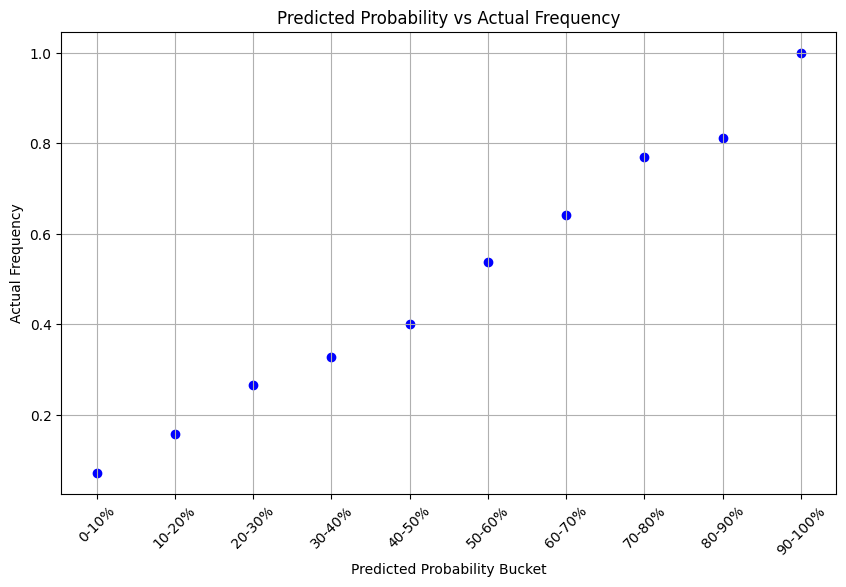

In [379]:
# Create a list of all predicted probabilities and their outcomes
predicted_probabilities = []
for index, row in data_test_compare.iterrows():
    predicted_probabilities.append((row['win_prob'], row['outcome'] == 1))
    predicted_probabilities.append((row['draw_prob'], row['outcome'] == 0))
    predicted_probabilities.append((row['lose_prob'], row['outcome'] == -1))

# Convert to DataFrame
prob_df = pd.DataFrame(predicted_probabilities, columns=['prob', 'outcome'])

# Create 10% buckets and calculate actual frequencies
buckets = np.arange(0, 1.1, 0.1)
midpoints = (buckets[:-1] + buckets[1:]) / 2
bucket_labels = [f'{int(100*mid-5)}-{int(100*mid+5)}%' for mid in midpoints]

# Initialize actual frequencies
actual_frequencies = []

for i in range(len(buckets) - 1):
    in_bucket = prob_df[(prob_df['prob'] >= buckets[i]) & (prob_df['prob'] < buckets[i+1])]
    if len(in_bucket) > 0:
        actual_frequency = in_bucket['outcome'].mean()
    else:
        actual_frequency = 0
    actual_frequencies.append(actual_frequency)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(midpoints, actual_frequencies, label='Actual Frequency', color='b')
plt.xticks(midpoints, bucket_labels, rotation=45)
plt.xlabel('Predicted Probability Bucket')
plt.ylabel('Actual Frequency')
plt.title('Predicted Probability vs Actual Frequency')
plt.grid(True)
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_39064\2143246775.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  actual_freq = df[df['outcome'] == outcome_val].groupby('bucket').size() / df.groupby('bucket').size()
C:\Users\andre\AppData\Local\Temp\ipykernel_39064\2143246775.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  actual_freq = df[df['outcome'] == outcome_val].groupby('bucket').size() / df.groupby('bucket').size()
C:\Users\andre\AppData\Local\Temp\ipykernel_39064\2143246775.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. P

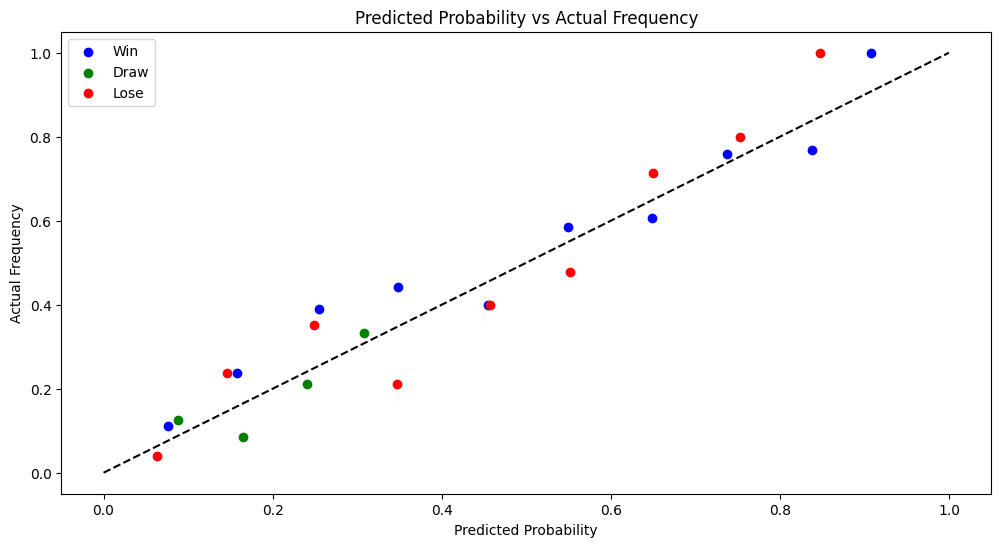

In [360]:
# Function to calculate actual and predicted frequencies
def calculate_frequencies(df, prob_col, outcome_val):
    bins = np.linspace(0, 1, 11)  # Create 10% buckets
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Midpoints of bins

    df['bucket'] = pd.cut(df[prob_col], bins=bins, labels=bin_centers, include_lowest=True)
    
    actual_freq = df[df['outcome'] == outcome_val].groupby('bucket').size() / df.groupby('bucket').size()
    predicted_freq = df.groupby('bucket')[prob_col].mean()
    
    return bin_centers, actual_freq, predicted_freq

# Calculate frequencies for win, draw, and lose probabilities
win_centers, win_actual, win_predicted = calculate_frequencies(data_test_compare, 'win_prob', 1)
draw_centers, draw_actual, draw_predicted = calculate_frequencies(data_test_compare, 'draw_prob', 0)
lose_centers, lose_actual, lose_predicted = calculate_frequencies(data_test_compare, 'lose_prob', -1)

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plots for win, draw, and lose
plt.scatter(win_predicted, win_actual, color='blue', label='Win')
plt.scatter(draw_predicted, draw_actual, color='green', label='Draw')
plt.scatter(lose_predicted, lose_actual, color='red', label='Lose')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference

plt.xlabel('Predicted Probability')
plt.ylabel('Actual Frequency')
plt.title('Predicted Probability vs Actual Frequency')
plt.legend()
plt.show()